# LSTM

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import copy

import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output
np.random.seed(42)

In [2]:
with open('data/russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

In [3]:
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  53


In [4]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'g': 0,
 'd': 1,
 't': 2,
 'k': 3,
 'f': 4,
 'T': 5,
 '-': 6,
 'P': 7,
 'r': 8,
 'J': 9,
 'a': 10,
 'A': 11,
 'h': 12,
 's': 13,
 'S': 14,
 'N': 15,
 'm': 16,
 'v': 17,
 'C': 18,
 'D': 19,
 'o': 20,
 'b': 21,
 'V': 22,
 'u': 23,
 'j': 24,
 'c': 25,
 'L': 26,
 'i': 27,
 'E': 28,
 'G': 29,
 'z': 30,
 '\xa0': 31,
 'w': 32,
 'В': 33,
 'M': 34,
 'I': 35,
 'n': 36,
 "'": 37,
 'O': 38,
 'R': 39,
 'l': 40,
 'Z': 41,
 'K': 42,
 ',': 43,
 'H': 44,
 'y': 45,
 'U': 46,
 'Y': 47,
 'B': 48,
 'F': 49,
 'e': 50,
 ' ': 51,
 'p': 52}

In [5]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [6]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [7]:
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[51 11 21 10 21  3 20 51 51 51]
 [51 18 12 27 12 10 25 12 50 17]
 [51 35 13 10 27  3 20 17 51 51]
 [51 15 10  3 12 10 16  3 27 36]
 [51 46 13  2 50 36  3 20 51 51]]


In [8]:
MAX_LENGTH = max(map(len, names))
sample = to_matrix(np.random.choice(names, size=5), token_to_id, max_len=MAX_LENGTH)

In [9]:
encoded_data = np.zeros(shape=(5, MAX_LENGTH, len(token_to_id)))

for text_i, text in enumerate(encoded_data):
    for letter_i, letter in enumerate(text):
        encoded_data[text_i, letter_i, sample[text_i, letter_i]] = 1

encoded_data.shape

(5, 21, 53)

In [10]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return x.dot(self.w) + self.b

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        w_grad = self.input.T.dot(output_error)
        b_grad = np.ones((1, len(output_error))).dot(output_error)
        input_error = output_error.dot(self.w.T)

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

In [11]:
def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)

def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

def sigmoid(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function derivative
    """
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def softmax(z: np.array) -> np.array:
    """
    Softmax function
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)

def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

![](./images/lstm.png)
![](./images/graph_meanings.png)

In [12]:
class LSTM:
    def __init__(
        self,
        n_input,
        n_hidden,
        bptt_trunc=4
    ):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.bptt_trunc = bptt_trunc
        
        self.forget_gate = Linear(n_input + n_hidden, n_hidden)
        self.forget_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.input_layer_gate = Linear(n_input + n_hidden, n_hidden)
        self.input_layer_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.candidate_gate = Linear(n_input + n_hidden, n_hidden)
        self.candidate_gate_activation = Activation(tanh, tanh_derivative)
        self.output_gate = Linear(n_input + n_hidden, n_hidden)
        self.output_gate_activation = Activation(sigmoid, sigmoid_derivative)
        self.output_to_logits = Linear(n_hidden, n_input)
        
        self.x_and_h = None
        self.hidden_states = None
        self.cell_states = None
        
        self.forget_inputs = None
        self.forget_states = None
        
        self.input_inputs = None
        self.input_states = None
        
        self.candidate_inputs = None
        self.candidate_states = None
        
        self.output_input = None
        self.output_states = None
        
        self.outputs = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def set_optimizer(self, optimizer) -> None:
        self.forget_gate.set_optimizer(optimizer)
        self.input_layer_gate.set_optimizer(optimizer)
        self.candidate_gate.set_optimizer(optimizer)
        self.output_gate.set_optimizer(optimizer)
        self.output_to_logits.set_optimizer(optimizer)
        
    def forward(self, x):
        self.input = x
        batch_size, timesteps, input_dim = x.shape
        
        self.x_and_h = np.zeros((batch_size, timesteps, self.n_input+self.n_hidden))
        self.hidden_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        self.cell_states = np.zeros((batch_size, timesteps+1, self.n_hidden))
        
        self.forget_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.forget_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.input_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.input_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.candidate_inputs = np.zeros((batch_size, timesteps, self.n_hidden))
        self.candidate_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.output_input = np.zeros((batch_size, timesteps, self.n_hidden))
        self.output_states = np.zeros((batch_size, timesteps, self.n_hidden))
        
        self.outputs = np.zeros((batch_size, timesteps, self.n_input))

        self.hidden_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        self.cell_states[:, -1] = np.zeros((batch_size, self.n_hidden))
        for t in range(timesteps):
            # соединяем вход и прошлый h
            self.x_and_h[:, t] = np.concatenate((x[:, t], self.hidden_states[:, t-1]), axis=1)
            
            # forget gate проход
            self.forget_inputs[:, t] = self.forget_gate(self.x_and_h[:, t])
            self.forget_states[:, t] = self.forget_gate_activation(self.forget_inputs[:, t])
            
            # выбор кандидатов для C
            self.input_inputs[:, t] = self.input_layer_gate(self.x_and_h[:, t])
            self.input_states[:, t] = self.input_layer_gate_activation(self.input_inputs[:, t])
            
            self.candidate_inputs[:, t] = self.candidate_gate(self.x_and_h[:, t])
            self.candidate_states[:, t] = self.candidate_gate_activation(self.candidate_inputs[:, t])
            
            self.cell_states[:, t] = self.forget_states[:, t] * self.cell_states[:, t-1]\
            + self.input_states[:, t] * self.candidate_states[:, t]
            
            self.output_input[:, t] = self.output_gate(self.x_and_h[:, t])
            self.output_states[:, t] = self.output_gate_activation(self.output_input[:, t])
            
            self.hidden_states[:, t] = self.output_states[:, t] * tanh(self.cell_states[:, t])
            
            # дополнительный слой, не указан на рисунке, для перевода состояния в логиты выхода
            self.outputs[:, t] = self.output_to_logits(self.hidden_states[:, t])

        return self.outputs
    
    def backward(self, output_error):        
        _, timesteps, _ = output_error.shape

        input_error = np.zeros_like(output_error)
        for t in np.arange(timesteps)[::-1]:
            # в разные моменты времени у слоев был разный вход, необходимо искусственно его поменять
            self.forget_gate.input = self.x_and_h[:, t]
            self.forget_gate_activation.input = self.forget_inputs[:, t]
            self.input_layer_gate.input = self.x_and_h[:, t]
            self.input_layer_gate_activation.input = self.input_inputs[:, t]
            self.candidate_gate.input = self.x_and_h[:, t]
            self.candidate_gate_activation.input = self.candidate_inputs[:, t]
            self.output_gate.input = self.x_and_h[:, t]
            self.output_gate_activation.input = self.output_input[:, t]
            self.output_to_logits.input = self.hidden_states[:, t]
            
            # проход по нижнему уровню
            hidden_error = self.output_to_logits.backward(output_error[:, t])
            # та, что идет вверх
            cell_error = tanh_derivative(self.cell_states[:, t]) * self.output_states[:, t] * hidden_error
            # ошибка идет и вниз и вверх
            hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t])
            # та, что идет вниз
            hidden_error = self.output_gate.backward(hidden_error)

            
            # идем по верху
            hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t]
            hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)
            
            hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t]
            hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)
            
            hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t-1]
            hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
            
            # добавляются ошибки с мест копии
            hidden_error += hidden_candidate_error
            hidden_error += hidden_inputs_error
            hidden_error += hidden_forget_error
            
            # ошибка, которая по времени уходит по низу назад
            hidden_error = hidden_error[:, self.n_input:]
            # ошибка, которая по времени уходит по верху назад
            cell_error = cell_error * self.forget_states[:, t]
            # ошибка входа
            input_error[:, t] = hidden_error[:, :self.n_input]
            
            for t_ in np.arange(max(0, t - self.bptt_trunc), t)[::-1]:
                # проход по времени
                self.forget_gate.input = self.x_and_h[:, t_]
                self.forget_gate_activation.input = self.forget_inputs[:, t_]
                self.input_layer_gate.input = self.x_and_h[:, t_]
                self.input_layer_gate_activation.input = self.input_inputs[:, t_]
                self.candidate_gate.input = self.x_and_h[:, t_]
                self.candidate_gate_activation.input = self.candidate_inputs[:, t_]
                self.output_gate.input = self.x_and_h[:, t_]
                self.output_gate_activation.input = self.output_input[:, t_]
                
                # та, что идет по верху
                cell_error += tanh_derivative(self.cell_states[:, t_]) * self.output_states[:, t_]\
                * hidden_error
                
                hidden_error = self.output_gate_activation.backward(hidden_error) * tanh(self.cell_states[:, t_])
                # та, что идет вниз
                hidden_error = self.output_gate.backward(hidden_error)
                
                hidden_candidate_error = self.candidate_gate_activation.backward(cell_error) * self.input_states[:, t_]
                hidden_candidate_error = self.candidate_gate.backward(hidden_candidate_error)

                hidden_inputs_error = self.input_layer_gate_activation.backward(cell_error) * self.candidate_states[:, t_]
                hidden_inputs_error = self.input_layer_gate.backward(hidden_inputs_error)

                hidden_forget_error = self.forget_gate_activation.backward(cell_error) * self.cell_states[:, t_-1]
                hidden_forget_error = self.forget_gate.backward(hidden_forget_error)
                
                # добавляются ошибки с мест копии
                hidden_error += hidden_candidate_error
                hidden_error += hidden_inputs_error
                hidden_error += hidden_forget_error

                # ошибка которая по времени уходит по низу назад
                hidden_error = hidden_error[:, self.n_input:]
                cell_error = cell_error * self.forget_states[:, t_]

        return input_error

![](./images/lstm_output.png)

In [13]:
lstm_unit = LSTM(n_input=len(token_to_id),
    n_hidden=64,
    bptt_trunc=15)

lstm_unit.set_optimizer(ADAM())

In [14]:
encoded_data.shape

(5, 21, 53)

In [15]:
lstm_unit.forward(encoded_data).shape

(5, 21, 53)

In [16]:
pred = lstm_unit(encoded_data)

loss = 0
for t in range(sample.shape[1]-1):
    loss += cross_entropy_loss(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

errors = np.zeros(shape=(5, MAX_LENGTH-1, len(token_to_id)))
for t in range(errors.shape[1]-1):
    errors[:, t, :] = cross_entropy_loss_derivative(sample[:, t+1].reshape(-1, 1), pred[:, t, :])

lstm_unit.backward(errors)

array([[[ 0.01841832, -0.00299377, -0.01709173, ...,  0.0187551 ,
         -0.01542174,  0.00738827],
        [ 0.00610701,  0.0004487 ,  0.00323593, ...,  0.00307519,
         -0.0059377 ,  0.00682948],
        [ 0.00200931,  0.00614388, -0.0010309 , ..., -0.00786876,
          0.00463106, -0.00482423],
        ...,
        [-0.00638979,  0.00315084, -0.00743177, ...,  0.00574639,
          0.00707862,  0.00414502],
        [-0.00145176, -0.00203039, -0.01251759, ...,  0.0107941 ,
          0.00205527,  0.00915858],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.01045198,  0.00379643,  0.00421158, ..., -0.00409587,
          0.0142586 ,  0.00746141],
        [-0.0042876 ,  0.01150004,  0.00437068, ..., -0.0130914 ,
          0.01422028, -0.00884061],
        [ 0.01740552, -0.02266821, -0.0144504 , ...,  0.00951029,
         -0.02038288,  0.00134361],
        ...,
        [-0.00645534,  0.00315477, -0.00743469, ...,  

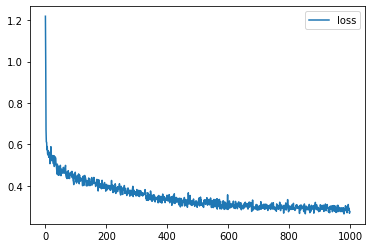

In [17]:
lstm_unit = LSTM(
    n_input=len(token_to_id),
    n_hidden=64,
    bptt_trunc=15
)
lstm_unit.set_optimizer(ADAM(learning_rate=0.0001))

batch_size = 64
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(names, size=batch_size, replace=False), token_to_id, max_len=MAX_LENGTH)
    
    encoded_data = np.zeros(shape=(batch_size, MAX_LENGTH, len(token_to_id)))

    for text_i, text in enumerate(encoded_data):
        for letter_i, letter in enumerate(text):
            encoded_data[text_i, letter_i, batch_ix[text_i, letter_i]] = 1
    
    pred = lstm_unit(encoded_data)

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    lstm_unit.backward(errors)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [18]:
history[-1]

0.2752717450505818

In [19]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)
        encoded_data = np.zeros(shape=(1, max_length, len(token_to_id)))

        for text_i, text in enumerate(encoded_data):
            for letter_i, letter in enumerate(text):
                encoded_data[text_i, letter_i, x_sequence[text_i, letter_i]] = 1

        pred = char_rnn(encoded_data)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [20]:
for _ in range(10):
    print(generate_sample(lstm_unit, seed_phrase=' ', temperature=0.4))

 Maryov              
 Shakhahin           
 Avarov              
 Hulanov             
 Agarin              
 Poarov              
 Abalusky            
 Abarokov            
 Dalenkov            
 Makhanev            


In [21]:
lstm_unit(encoded_data)[1].argmax(axis=1)

array([11, 12, 12,  8, 13, 36, 51, 13,  3, 17, 51, 51, 51, 51, 51, 51, 51,
       51, 51, 51, 51], dtype=int64)

In [22]:
batch_ix[1, 1:]

array([14, 25, 50,  2, 27, 36,  2, 13, 50, 17, 51, 51, 51, 51, 51, 51, 51,
       51, 51, 51])

In [23]:
with open('./style.css') as f:
    style = f.read()
HTML(style)